In [1]:
import pandas as pd

projects1_1 = pd.read_csv('kickstarter-projects/ks-projects-201612.csv')
projects1_2 = pd.read_csv('kickstarter-projects/ks-projects-201801.csv')
projects2 = pd.read_csv('funding-successful-projects-on-kickstarter/train.csv')

/media/sdb1/nfs/iped/miniconda2/envs/dedos/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Clean up the column names, which for some reason have spaces after them
projects1_1.columns = [x.strip() for x in projects1_1.columns]

# Get the common columns between the two datasets
overlapping_columns = list(set(projects1_1.columns) & set(projects1_2.columns))

# Join the datasets together
projects1 = projects1_1[overlapping_columns].append(projects1_2[overlapping_columns])

# Drop duplicates
projects1 = projects1.drop_duplicates('name')

In [3]:
projects = projects1.merge(projects2, on='name', how='inner')
projects = projects.dropna()
projects.columns

Index([u'category', u'name', u'usd pledged', u'main_category', u'country_x',
       u'pledged', u'backers', u'currency_x', u'state', u'deadline_x', u'ID',
       u'launched', u'goal_x', u'project_id', u'desc', u'goal_y', u'keywords',
       u'disable_communication', u'country_y', u'currency_y', u'deadline_y',
       u'state_changed_at', u'created_at', u'launched_at', u'backers_count',
       u'final_status'],
      dtype='object')

In [4]:
renames = {
    'country_x': 'country',
    'currency_x': 'currency',
    'goal_x': 'goal',
    'goal_y': 'goal',
    'country_y': 'country',
    'currency_y': 'currency',
    'deadline_y': 'deadline',
    'backers_count': 'backers'
}

to_num = lambda x: pd.to_numeric(x, errors='coerce')
to_date = lambda x: pd.to_datetime(x, unit='s').astype(int)
conversions = {
    'usd pledged' : to_num,
    'backers': to_num,
    'deadline': to_date,
    'launched_at': to_date,
    'state_changed_at': to_date,
    'created_at': to_date,
    'goal': to_num,
    'pledged': to_num,
}

drops = (
    'ID', 'project_id', 'keywords', 'deadline_x', 'launched'
)

In [5]:
def clean_df(df, renames=None, retypes=None, drops=None):
    if renames is not None:
        for orig, new in renames.items():
            print orig
            if new in df.columns:
                diffs = df[[orig, new]][df[orig] != df[new]]
                print diffs[:10]
                df = df.drop(orig, axis=1)
            else:
                df = df.rename({orig: new}, axis=1)
    print df.columns
    if retypes is not None:
        for col, conv in retypes.items():
            dfcol = df[col]
            df = df.drop(col, axis=1)
            df[col] = conv(dfcol)
    if drops is not None:
        for col in drops:
            df = df.drop(col, axis=1)
            
    df = df.dropna(axis=1, how='all')
    df = df.dropna(axis=0, how='any')
    return df
            
cleaned = clean_df(projects, renames, conversions, drops)   

deadline_y
currency_x
backers_count
   backers_count backers
0              3       3
1              0       0
2             16      16
3             20      20
4              3       3
5            571     571
6              1       1
7             30      30
8            157     157
9            277     277
goal_x
goal_y
    goal_y   goal
0  45000.0  45000
1   2500.0   2500
2   1500.0   1500
3   3000.0   3000
4    500.0    500
5  17757.0  17757
6   3500.0   3500
7  25000.0  25000
8   4000.0   4000
9  15000.0  15000
currency_y
     currency_y currency
106         USD      GBP
322         USD      CAD
378         CAD      USD
1126        USD      CAD
1263        USD      GBP
1873        CAD      USD
1959        USD      CAD
2013        AUD      USD
2330        USD      GBP
2928        GBP      CAD
country_x
country_y
     country_y country
106         US      GB
322         US      CA
378         CA      US
1126        US      CA
1263        US      GB
1873        CA      US
1959      

In [7]:
cleaned

,category,name,main_category,country,currency,state,desc,disable_communication,final_status,pledged,deadline,goal,usd pledged,created_at,backers,launched_at,state_changed_at
0,Narrative Film,Where is Hank?,Film & Video,US,USD,failed,"Abandoned Property. Sounds of struggle, muffle...",False,0,220.00,1361834450000000000,45000.0,220.000000,1357603284000000000,3.0,1357946450000000000,1361834450000000000
1,Nonfiction,Of Jesus and Madmen,Publishing,CA,CAD,failed,This is an autobiography of my personal experi...,False,0,0.00,1381335577000000000,2500.0,0.000000,1378130153000000000,0.0,1378743577000000000,1381335577000000000
2,Comic Books,The Beard,Comics,US,USD,failed,'The beard' is a comedy based comic about an a...,False,0,395.00,1415482072000000000,1500.0,395.000000,1412172842000000000,16.0,1412886472000000000,1415482072000000000
3,Art Books,Notes From London: Above & Below,Publishing,US,USD,failed,Notes From London: Above & Below is an unusual...,False,0,789.00,1431285654000000000,3000.0,789.000000,1428526605000000000,20.0,1428693654000000000,1431285655000000000
4,Drinks,Mountain brew: A quest for alcohol sustainability,Food,NO,NOK,failed,This is the start of an exiting venture of bre...,False,0,48.00,1424888253000000000,500.0,6.180008,1422045831000000000,3.0,1422296253000000000,1424888253000000000
5,Webseries,Permaculture Skills,Film & Video,CA,CAD,successful,A film series distilled from 20 days of cold-c...,False,1,48905.00,1418576520000000000,17757.0,43203.251145,1407959136000000000,571.0,1415984520000000000,1418576521000000000
6,Food Trucks,Daily Brew Coffee,Food,GB,GBP,failed,Daily Brew an artisan cafe based in a Piaggio ...,False,0,21.00,1427817992000000000,3500.0,32.415261,1425208254000000000,1.0,1425229592000000000,1427817994000000000
7,Public Art,BB130A,Art,US,USD,failed,This monumental event will exhibit how people ...,False,0,1395.00,1364080048000000000,25000.0,1395.000000,1360376872000000000,30.0,1360627648000000000,1364080048000000000
8,Indie Rock,Arrows & Sound Debut Album,Music,US,USD,successful,"Philip Zach, formerly of Remedy Drive, is reco...",False,1,8641.34,1337382271000000000,4000.0,8641.340000,1328116784000000000,157.0,1334790271000000000,1337382271000000000
9,Indie Rock,Help Scott Reynolds Make a New Record!,Music,US,USD,successful,It's been 4 years since his last release. He's...,False,1,17499.99,1346604196000000000,15000.0,17499.990000,1334611356000000000,277.0,1344012196000000000,1346604197000000000


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def summarize(df):
    n_failed = np.count_nonzero(df.final_status == 1)
    print("{} Failed".format(n_failed))
    n_success = np.count_nonzero(df.final_status == 0)
    print("{} Success".format(n_success))
    
def hist_by_group(df, groupname, n_groups=None):
    if n_groups is None:
        grouped = df.groupby(groupname)
        names = grouped.groups.keys()
    else:
        pcts = np.arange(0, 1, 1/float(n_groups))
        quantiles = df[groupname].quantile(pcts)
        inds = np.digitize(df[groupname], quantiles)
        grouped = df.groupby(inds)
        names = []
        for a, b in zip(pcts, pcts[1:]):
            names.append('{}-{}'.format(quantiles[a], quantiles[b]))
        names.append('{}-{}'.format(quantiles[b], max(df[groupname])))
    
    num_groups = len(grouped)
    
    successes = []
    failures = []

    margins = []
    totals = []
    
    for name, group in grouped:

        n_failed = np.count_nonzero(group.final_status == 0)
        n_success = np.count_nonzero(group.final_status == 1)
        successes.append(float(n_success) / len(group))
        failures.append(float(n_failed) / len(group))
        
        margins.append(np.abs(n_success - n_failed))
        totals.append(n_success + n_failed)
    
    bar_width = .25
    indices = np.arange(num_groups)
    
    
    margins, totals, successes, failures  = \
        zip(*sorted(zip(margins, totals, successes, failures), key=lambda x: x[0]/(x[0] + x[1])))
    
    plt.bar(indices, successes, bar_width, color='g', label='successes')
    plt.bar(indices + bar_width, failures, bar_width, color='r', label='failures')
    plt.xticks(indices + bar_width * 1.5, names)
    plt.gca().set_ylabel("Percentage")
    plt.gca().set_xlabel(groupname)
    plt.legend()
    
def rolling_success(df):
    
    statuses = df[['goal', 'final_status']][(df['final_status'] == 1) | (df['final_status'] == 0)]
    
    grouped = statuses.groupby((statuses['goal'] / 1000).astype(int))

    not_alone = grouped.size() > 10
    
    success_rate = grouped['final_status'].mean()[not_alone]
    
    ax = plt.subplot()
    print(success_rate.shape)
    plt.plot(success_rate.index, success_rate, '.')
    ax.set_xscale('log')
    ax.set_xlabel("Goal")
    ax.set_ylabel("Success Ratio")


31879 Failed
68453 Success


<IPython.core.display.Javascript object>


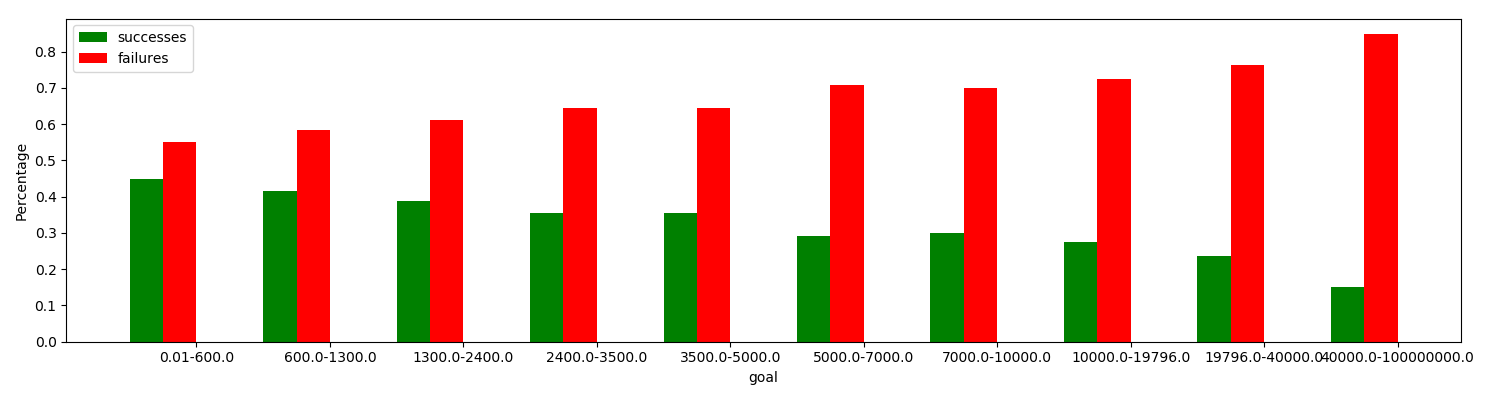

<IPython.core.display.Javascript object>


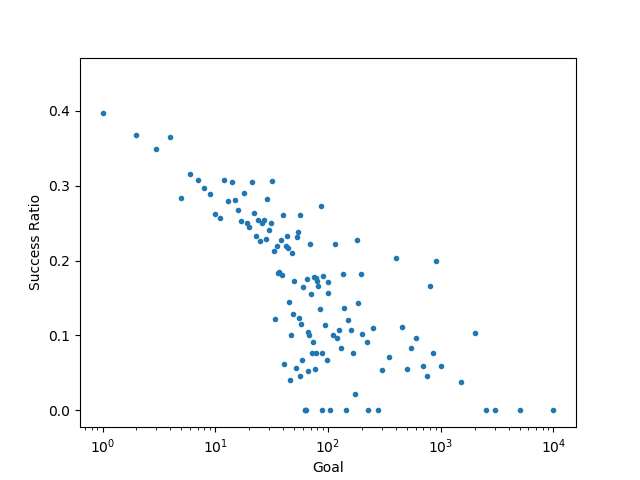

(126,)


In [9]:
%matplotlib notebook

summarize(cleaned)
plt.figure(figsize=(15, 4))
hist_by_group(cleaned, 'goal', 10)
plt.tight_layout()

plt.figure()
rolling_success(cleaned)


<IPython.core.display.Javascript object>


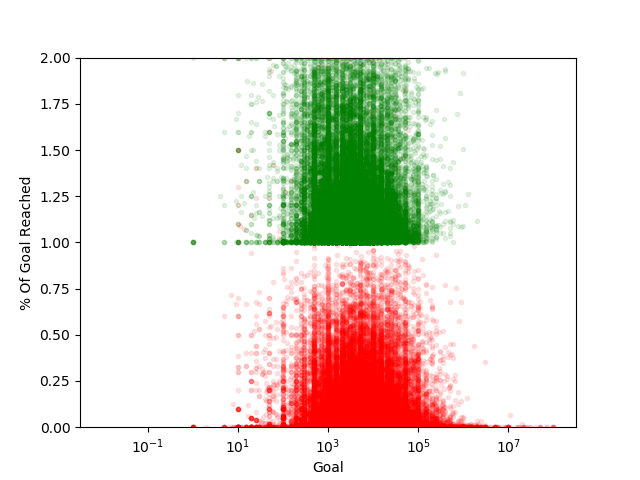

(0, 2)

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

successes = cleaned[cleaned.state == 'successful']
failures = cleaned[cleaned.state != 'successful']

ax = plt.subplot()
plt.plot(failures.goal, failures.pledged/failures.goal, 'r.', alpha=.1)
plt.plot(successes.goal, successes.pledged/successes.goal, 'g.', alpha=.1)
ax.set_xscale('log')
ax.set_xlabel('Goal')
ax.set_ylabel('% Of Goal Reached')
plt.ylim([0, 2])

In [10]:
cleaned.columns

Index([u'category', u'name', u'main_category', u'country', u'currency',
       u'state', u'desc', u'disable_communication', u'final_status',
       u'pledged', u'deadline', u'goal', u'usd pledged', u'created_at',
       u'backers', u'launched_at', u'state_changed_at'],
      dtype='object')

In [11]:
from sklearn.feature_extraction import DictVectorizer

def create_feature_matrix(df, scalars=None, categoricals=None, splits=None):
    # Should be done using apply or map or something like that
    ds = []
    Y = []
    for _, r in df.iterrows():
        d = {}
        if scalars is not None:
            for sca in scalars:
                try:
                    d[sca] = pd.to_numeric(r[sca])
                except:
                    print(d[sca])
                    continue
                        
        if categoricals is not None:
            for cat in categoricals:
                d[cat + r[cat]] = 1
        if splits is not None:
            for spl in splits:
                d.update({(spl+'-'+word): 1 for word in r[spl].split()})
        ds.append(d)
    v = DictVectorizer()
    print("Vectorizing")
    X = v.fit_transform(ds)
    return X.astype(float), v.get_feature_names()


In [12]:
all_features, all_feature_names = create_feature_matrix(cleaned,
    ('goal', ),
    ('category', 'main_category', 'country',),
    ('desc', 'name',)
)

Vectorizing


In [13]:
string_features, string_feature_names = create_feature_matrix(cleaned,
    None,
    ('category','main_category', 'country'),
    ('desc', 'name')
)

Vectorizing


In [14]:
import numpy as np
import sklearn
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

def run_classifier(X, Y, Clf, *args, **kwargs):
    kf = KFold(n_splits=5)
    
    p_corrects = []
    for train, test in kf.split(X):
        print("Folding")
        x_train = X[train]
        x_test = X[test]
        
        y_train = Y[train]
        y_test = Y[test]
        
        clf = Clf(*args, **kwargs)
        clf.fit(x_train, y_train)
        
        predY = clf.predict(x_test)
    
        p_corrects.append(np.count_nonzero(predY == y_test) / float(len(y_test)))
        print("Fold success: {}".format(p_corrects[-1]))
        
    print("Mean correct: {}".format(np.mean(p_corrects)))

Y = (cleaned.state == 'successful').values


In [15]:
run_classifier(all_features, Y, LinearSVC)

Folding
Fold success: 0.516519659142
Folding
Fold success: 0.494294114716
Folding
Fold success: 0.483753613077
Folding
Fold success: 0.685139041164
Folding
Fold success: 0.689923253264
Mean correct: 0.573925936273


In [16]:
run_classifier(string_features, Y, LinearSVC)

Folding
Fold success: 0.708177605023
Folding
Fold success: 0.712513081178
Folding
Fold success: 0.712698096282
Folding
Fold success: 0.707066679956
Folding
Fold success: 0.709757799262
Mean correct: 0.71004265234


In [17]:
run_classifier(all_features, Y, DecisionTreeClassifier, max_depth=3)
run_classifier(all_features, Y, DecisionTreeClassifier, max_depth=4)
run_classifier(all_features, Y, DecisionTreeClassifier, max_depth=5)


Folding
Fold success: 0.651318084417
Folding
Fold success: 0.663028853341
Folding
Fold success: 0.654390511313
Folding
Fold success: 0.65728097279
Folding
Fold success: 0.653294129373
Mean correct: 0.655862510247
Folding
Fold success: 0.675237952858
Folding
Fold success: 0.688692878856
Folding
Fold success: 0.680853184491
Folding
Fold success: 0.681650553175
Folding
Fold success: 0.68065384232
Mean correct: 0.68141768234
Folding
Fold success: 0.675138286739
Folding
Fold success: 0.688692878856
Folding
Fold success: 0.680853184491
Folding
Fold success: 0.681650553175
Folding
Fold success: 0.68065384232
Mean correct: 0.681397749116


In [18]:
run_classifier(string_features, Y, DecisionTreeClassifier, max_depth=8)

Folding
Fold success: 0.702247470972
Folding
Fold success: 0.714556236607
Folding
Fold success: 0.710555167946
Folding
Fold success: 0.702681152198
Folding
Fold success: 0.705820791388
Mean correct: 0.707172163822
Folding
Fold success: 0.706234115712
Folding
Fold success: 0.718592714407
Folding
Fold success: 0.714242998106
Folding
Fold success: 0.707066679956
Folding
Fold success: 0.708113226353
Mean correct: 0.710849946907
Folding
Fold success: 0.714107739074
Folding
Fold success: 0.725120845169
Folding
Fold success: 0.723612080136
Folding
Fold success: 0.71523970896
Folding
Fold success: 0.71339579388
Mean correct: 0.718295233444


In [19]:

dtree = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=10)
dtree.fit(string_features, Y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

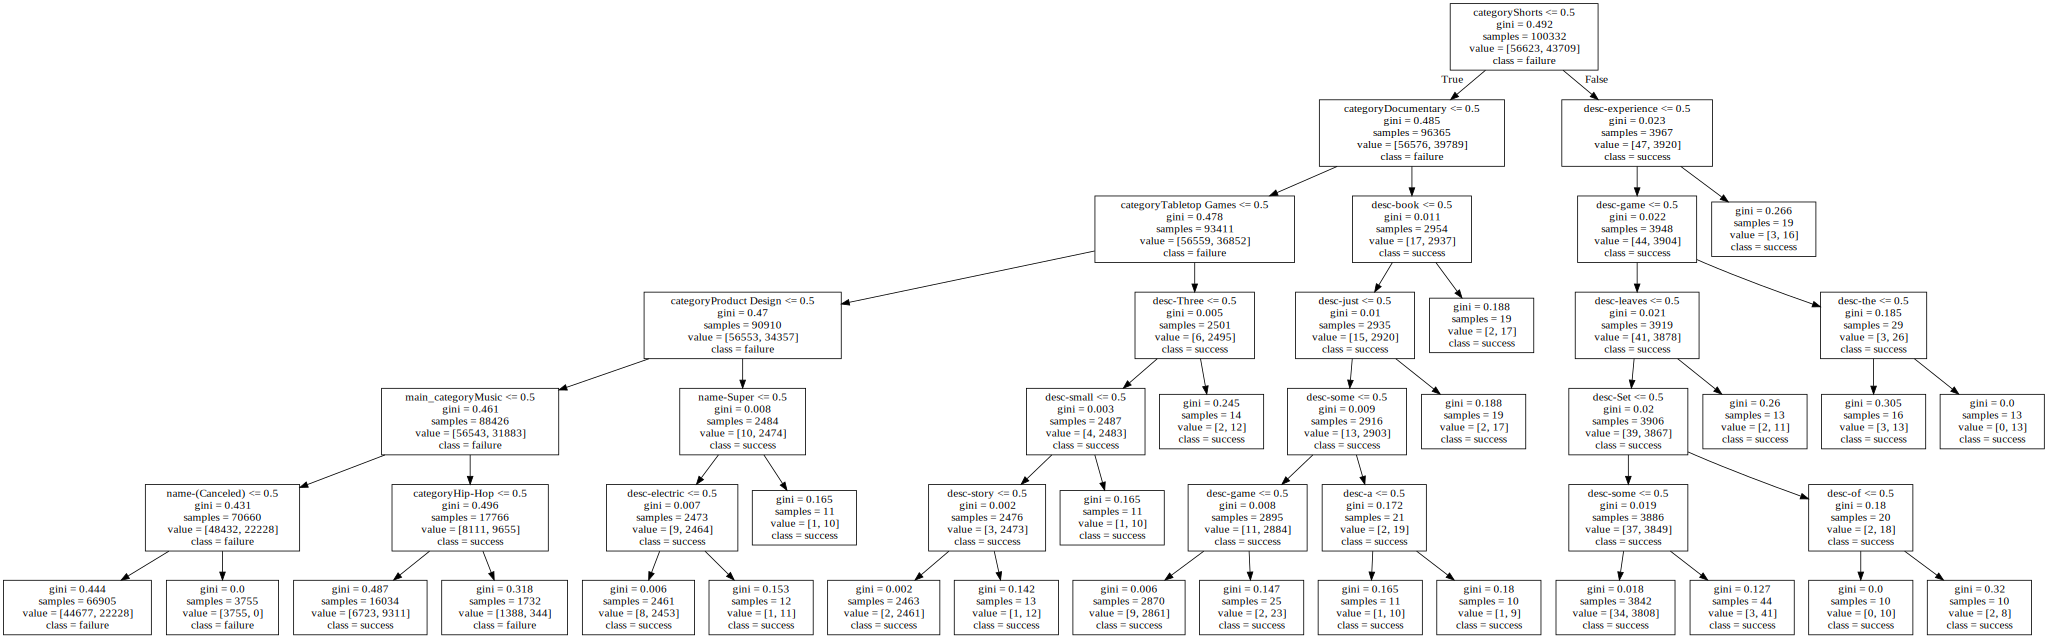

In [20]:
from sklearn.tree import export_graphviz
from graphviz import Source

dot =export_graphviz(dtree, out_file=None, feature_names = string_feature_names, class_names=('failure', 'success'))
Source(dot)